(categorical_hgf)=
# The categorical Hierarchical Gaussian Filter

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/1.´3-CAtegorical_HGF.ipynb)

```{warning}
The categorical state node and the categorical state-transition nodes are still work in progress. The examples provided here are given for illustration. Things may change or not work until the official publication.
```

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install pyhgf

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import seaborn as sns
from jax import grad, jit, vjp
from jax.tree_util import Partial
from pytensor.graph import Apply, Op

from pyhgf import load_data
from pyhgf.model import HGF
from pyhgf.plots import plot_nodes

The binary state nodes that we introduced in the previous section are useful to encode information about stochastic boolean variables that are common in reinforcement learning and decision-making design. However, situations may occur where discrete variables can have more than two categories and therefore need to be encoded by a categorical distribution. Here, we introduce two probabilistic nodes tailored to handle this kind of variable: the **categorical state node** and the **categorical state-transition node**.

Both nodes are a generalisation of the binary HGFs (in the sense that they internally represent a collection of binary state nodes). We refer to **categorical HGF** in a broad sense for HGFs that can handle categorical distributions, but as we will illustrate below, there are many ways to do that and a more precise terminology is to refer to the kind of node used internally (the **categorical state node** and the **categorical state-transition node**).

## Simulating a dataset
We start by simulating a dataset on which we can apply the categorical HGFs. The dataset consists of a categorical input where the number of categories $K=10$. The underlying contingencies are generated by three Dirichlet distributions on which we sample 150 observations sequentially.

In [3]:
# generate some categorical inputs data using three underlying distributions
p1 = np.random.dirichlet(alpha=[1, 2, 3, 5, 9, 13, 17, 25, 30, 35])
p2 = np.random.dirichlet(alpha=[1, 2, 3, 5, 30, 30, 5, 3, 2, 1])
p3 = np.random.dirichlet(alpha=[35, 30, 25, 17, 13, 9, 5, 3, 2, 1])
input_data = np.array(
    [np.random.multinomial(n=1, pvals=p) for p in [p1, p2, p3] for _ in range(250)]
).T

The Dirichlet distributions are parametrized in such a way that it goes from a "skewed" distribution to a centred distribution to another "skewed" distribution. The resulting sequence of categorical observations then looks like this:

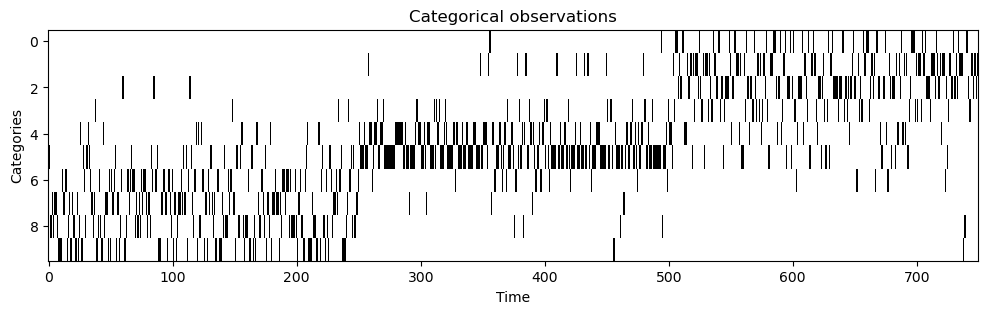

In [4]:
plt.figure(figsize=(12, 3))
plt.imshow(input_data, interpolation="none", aspect="auto", cmap="binary")
plt.ylabel("Categories")
plt.xlabel("Time")
plt.title("Categorical observations");

```{note}
The lower part of the figure represent the surprise associated with the categorical node. Here, we use the [Kullback-Leibler divergence between two Dirichlet distributions](https://statproofbook.github.io/P/dir-kl.html) as a measure of Bayesian surprise. The Kullback-Leibler divergence of the Dirichlet distribution $P$ from the Dirichlet distribution $Q$ is given by the following equation:

$$
KL[P||Q] = \ln{\frac{\Gamma(\sum_{i=1}^k\alpha_{1i})}{\Gamma(\sum_{i=1}^k\alpha_{2i})}} + \sum_{i=1}^k \ln{\frac{\Gamma(\alpha_{2i})}{\Gamma(\alpha_{1i})}} + \sum_{i=1}^k(\alpha_{1i} - \alpha_{2i}) \left[ \psi(\alpha_{1i}) - \psi(\sum_{i=1}^k \alpha_{1i}) \right]
$$

```

In [5]:
# adding a blank input time series for the categorical state node
# this is because the categorical state node does not receive anything
# only binary nodes are the actual inputs of the network
input_data = np.vstack([[0.0] * input_data.shape[1], input_data])

## The categorical state node

### Creating the probabilistic network

In [6]:
categorical_hgf = (
    HGF(model_type=None, verbose=False)
    .add_input_node(
        kind="categorical", 
        categorical_parameters={"n_categories": 10}, 
        binary_parameters={"omega_2": -2.0}
    ).init()
)

I0000 00:00:1701370938.749231   22878 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


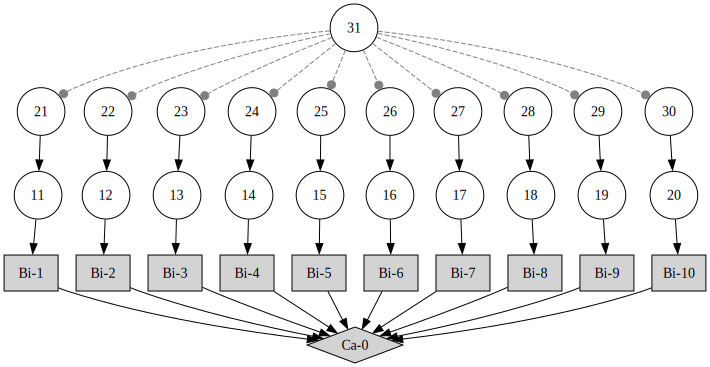

In [7]:
categorical_hgf.plot_network()

### Fitting the model forwards

In [8]:
categorical_hgf.input_data(input_data=input_data.T);

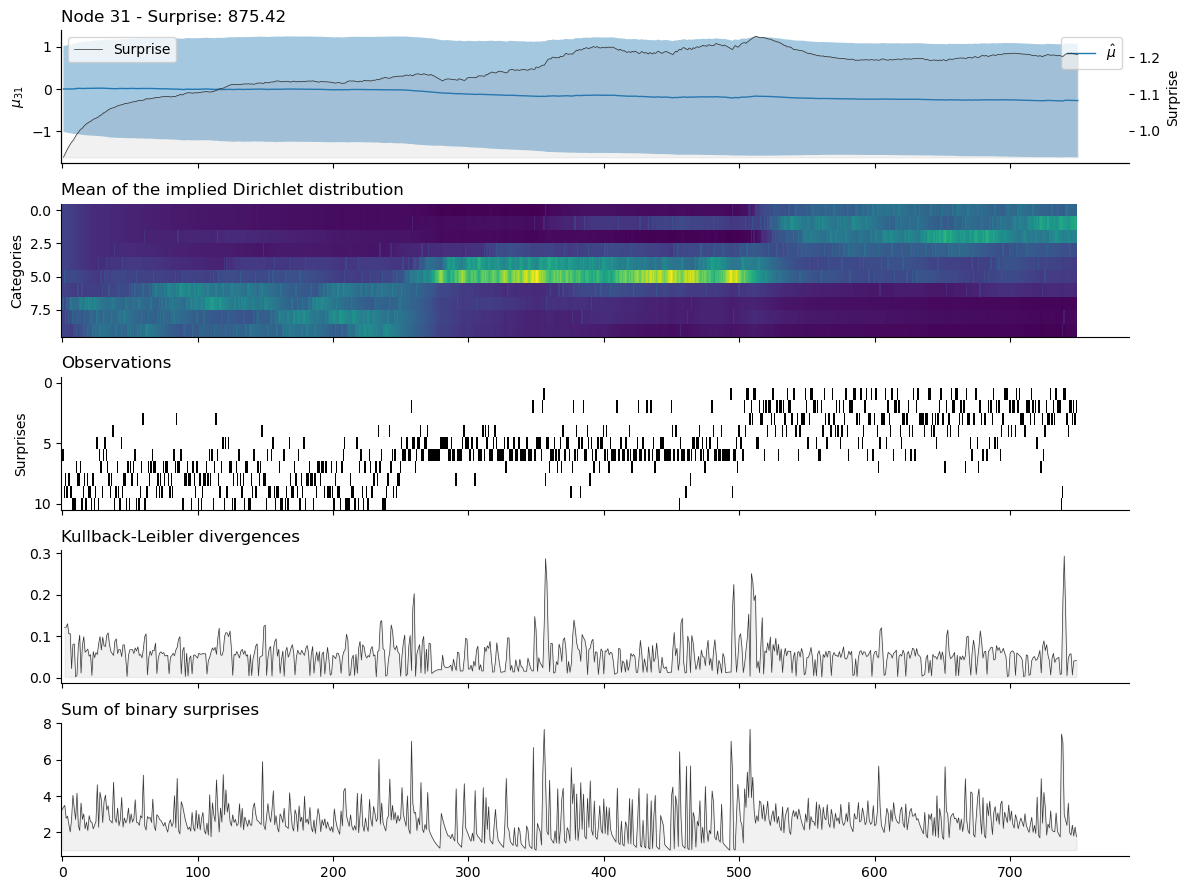

In [9]:
fig, axs = plt.subplots(nrows=5, figsize=(12, 9), sharex=True)
plot_nodes(categorical_hgf, node_idxs=31, axs=axs[0])
axs[1].imshow(categorical_hgf.node_trajectories[0]["mean"].T, interpolation="none", aspect="auto")
axs[1].set_title("Mean of the implied Dirichlet distribution", loc="left")
axs[1].set_ylabel("Categories")

# observations
axs[2].imshow(input_data, interpolation="none", aspect="auto", cmap="binary")
axs[2].set_title("Observations", loc="left")
axs[2].set_ylabel("Categories")

# surprise
axs[3].plot(
    np.arange(2, len(categorical_hgf.node_trajectories[0]["kl_divergence"])),
    categorical_hgf.node_trajectories[0]["kl_divergence"][2:],
    color="#2a2a2a",
    linewidth=0.5,
    zorder=-1,
    label="Surprise",
)
axs[3].fill_between(
    x=np.arange(2, len(categorical_hgf.node_trajectories[0]["kl_divergence"])),
    y1=categorical_hgf.node_trajectories[0]["kl_divergence"][2:],
    y2=categorical_hgf.node_trajectories[0]["kl_divergence"][2:].min(),
    color="#7f7f7f",
    alpha=0.1,
    zorder=-1,
)
axs[3].set_title("Kullback-Leibler divergences", loc="left")
axs[2].set_ylabel("Surprises")

axs[4].plot(
    np.arange(len(categorical_hgf.node_trajectories[0]["surprise"])),
    categorical_hgf.node_trajectories[0]["surprise"],
    color="#2a2a2a",
    linewidth=0.5,
    zorder=-1,
    label="Surprise",
)
axs[4].fill_between(
    x=np.arange(len(categorical_hgf.node_trajectories[0]["surprise"])),
    y1=categorical_hgf.node_trajectories[0]["surprise"],
    y2=categorical_hgf.node_trajectories[0]["surprise"].min(),
    color="#7f7f7f",
    alpha=0.1,
    zorder=-1,
)
axs[4].set_title("Sum of binary surprises", loc="left")
axs[2].set_ylabel("Surprises")

sns.despine()
plt.tight_layout()

In [10]:
categorical_hgf.node_trajectories[0]["alpha"]

Array([[1.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [2.0445216, 2.0445216, 2.0445216, ..., 2.5556629, 2.0445216,
        2.0445216],
       [2.1143956, 2.1143956, 2.1143956, ..., 2.222889 , 2.1143956,
        2.1143956],
       ...,
       [4.658279 , 6.851118 , 6.138325 , ..., 1.5104958, 1.6455219,
        1.5517552],
       [4.6345725, 7.415059 , 5.7136183, ..., 1.5093516, 1.6543119,
        1.5612062],
       [4.607764 , 7.0151772, 6.273489 , ..., 1.5081697, 1.6626433,
        1.5701842]], dtype=float32)

### Inference using MCMC sampling

In the binary and continuous HGF example, we have been using the {py:class}`pyhgf.distribution.HGFDistribution` class to create a PyMC-compatible distribution of the HGF. This was possible when using the most standard models as we can easily write a pre-defined distribution that fits exactly the network specification. However, when using more exotic network structures, as this is the case here with the categorical state nodes where the number of nodes in the network grows with the number of categories, we need a more flexible approach that can let us wrap a PyMC distribution for every kind of network we can have. 

This is what we are doing below (see [this blog post](https://www.pymc-labs.io/blog-posts/jax-functions-in-pymc-3-quick-examples/) and the [PyMC documentation](https://www.pymc.io/projects/examples/en/latest/case_studies/wrapping_jax_function.html) on how to do that). First, we start by creating a function that computes the surprise of the model, here using the Kullback-Leibler divergences of the implied Dirichlet distributions.

In [11]:
def categorical_surprise(omega_2, hgf, input_data):

    # replace with a new omega in the model
    for idx in np.arange(21, 31):
        hgf.attributes[idx]["tonic_volatility"] = omega_2

    # run the model forward again
    hgf.input_data(input_data=input_data.T)

    # compute the surprises using KL divergences
    surprise = hgf.node_trajectories[0]["kl_divergence"][2:].sum()

    # return an infinite surprise if the model could not fit at any point
    surprise = jnp.where(
        jnp.any(jnp.isnan(hgf.node_trajectories[0]["xi"])), jnp.inf, surprise
    )

    return surprise

surprise_fn = Partial(categorical_surprise, hgf=categorical_hgf, input_data=input_data)

We create both jitted and the vector-jacobian product requiered for a custom Op in PyTensor:

In [12]:
jitted_custom_op_jax = jit(surprise_fn)

def vjp_custom_op_jax(x, gz):
    _, vjp_fn = vjp(surprise_fn, x)
    return vjp_fn(gz)[0]

jitted_vjp_custom_op_jax = jit(vjp_custom_op_jax)

In [13]:
# The CustomOp needs `make_node`, `perform` and `grad`.
class CustomOp(Op):
    def make_node(self, x):
        # Create a PyTensor node specifying the number and type of inputs and outputs

        # We convert the input into a PyTensor tensor variable
        inputs = [pt.as_tensor_variable(x)]
        # Output has the same type and shape as `x`
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        # Evaluate the Op result for a specific numerical input

        # The inputs are always wrapped in a list
        (x,) = inputs
        result = jitted_custom_op_jax(x)
        # The results should be assigned inplace to the nested list
        # of outputs provided by PyTensor. If you have multiple
        # outputs and results, you should assign each at outputs[i][0]
        outputs[0][0] = np.asarray(result, dtype="float64")

    def grad(self, inputs, output_gradients):
        # Create a PyTensor expression of the gradient
        (x,) = inputs
        (gz,) = output_gradients
        # We reference the VJP Op created below, which encapsulates
        # the gradient operation
        return [vjp_custom_op(x, gz)]


class VJPCustomOp(Op):
    def make_node(self, x, gz):
        # Make sure the two inputs are tensor variables
        inputs = [pt.as_tensor_variable(x), pt.as_tensor_variable(gz)]
        # Output has the shape type and shape as the first input
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (x, gz) = inputs
        result = jitted_vjp_custom_op_jax(x, gz)
        outputs[0][0] = np.asarray(result, dtype="float64")

# Instantiate the Ops
custom_op = CustomOp()
vjp_custom_op = VJPCustomOp()

In [14]:
#with pm.Model() as model:
#    omega_2 = pm.Normal("omega_2", -2.0, 2)
#    pm.Potential("hgf", custom_op(omega_2))
#    categorical_idata = pm.sample(chains=2)

In [15]:
# az.plot_trace(categorical_idata)

## The categorical state-transition node

```{warning}
This is work in progress.
```

# System configuration

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Thu Nov 30 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

pyhgf : 0.0.12
jax   : 0.4.16
jaxlib: 0.4.16

jax       : 0.4.16
seaborn   : 0.12.2
pytensor  : 2.17.3
arviz     : 0.16.1
numpy     : 1.22.0
pymc      : 5.9.1
matplotlib: 3.7.1
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]

Watermark: 2.4.3

